In [2]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
from functions.data_visualization_gdal import *
from functions.model_saving_loading import *
from functions.smooth_tiled_predictions import predict_img_with_smooth_windowing
from functions.model_inference import *
import logging
logging.basicConfig(level=logging.WARNING)
logging.getLogger('matplotlib').setLevel(logging.INFO)  

In [3]:
%store -r RES 
%store -r WIDTH
%store -r HEIGHT
%store -r N_BANDS
%store -r N_CAT
%store -r TRAINING_YEARS 
%store -r TRAINING_SEASONS
%store -r MSK_PATH
%store -r MASK_FILE
%store -r MSK_RAW_PTH 
%store -r MSK_CLIP_PTH 
%store -r MAPPED_MSK_CLIP_PTH 
%store -r MSK_TILES_PTH
%store -r CLN_MSK_TILES_PTH
%store -r IMG_18_PATH 
%store -r IMG_18_FILE 
%store -r IMG_18_COMP_PTH 
%store -r IMG_18_CLIP_PTH 
%store -r IMG_18_NORM_PTH 
%store -r IMG_18_TILES_PTH 
%store -r CLN_IMG_18_TILES_PTH
%store -r IMG_19_PATH
%store -r IMG_19_FILE 
%store -r IMG_19_COMP_PTH
%store -r IMG_19_CLIP_PTH
%store -r IMG_19_NORM_PTH 
%store -r IMG_19_TILES_PTH
%store -r CLN_IMG_19_TILES_PTH 
%store -r IMG_21_PATH
%store -r IMG_21_FILE
%store -r IMG_21_COMP_PTH
%store -r IMG_21_CLIP_PTH
%store -r IMG_21_NORM_PTH
%store -r IMG_21_TILES_PTH
%store -r CLN_IMG_21_TILES_PTH
%store -r MODELS_DIR 
%store -r TRAIN_SPLIT
%store -r TEST_SPLIT
%store -r DATASETS_DIR
%store -r MODELS_TO_LOAD_DIR 
%store -r INFERENCE_INPUT_DIR
%store -r TILE_SIZE
%store -r N_CLASSES
%store -r lgnd

RES = RES
WIDTH = WIDTH
HEIGHT = HEIGHT
N_BANDS = N_BANDS
N_CAT = N_CAT
TRAINING_YEARS = TRAINING_YEARS
TRAINING_SEASONS = TRAINING_SEASONS
MSK_PATH = MSK_PATH
MASK_FILE = MASK_FILE
MSK_RAW_PTH = MSK_RAW_PTH
MSK_CLIP_PTH = MSK_CLIP_PTH
MAPPED_MSK_CLIP_PTH = MAPPED_MSK_CLIP_PTH
MSK_TILES_PTH = MSK_TILES_PTH
CLN_MSK_TILES_PTH = CLN_MSK_TILES_PTH
IMG_18_PATH = IMG_18_PATH
IMG_18_FILE = IMG_18_FILE
IMG_18_COMP_PTH = IMG_18_COMP_PTH
IMG_18_CLIP_PTH = IMG_18_CLIP_PTH
IMG_18_NORM_PTH = IMG_18_NORM_PTH
IMG_18_TILES_PTH = IMG_18_TILES_PTH
CLN_IMG_18_TILES_PTH = CLN_IMG_18_TILES_PTH
IMG_19_PATH = IMG_19_PATH
IMG_19_FILE = IMG_19_FILE
IMG_19_COMP_PTH = IMG_19_COMP_PTH
IMG_19_CLIP_PTH = IMG_19_CLIP_PTH
IMG_19_NORM_PTH = IMG_19_NORM_PTH
IMG_19_TILES_PTH = IMG_19_TILES_PTH
CLN_IMG_19_TILES_PTH = CLN_IMG_19_TILES_PTH

IMG_21_PATH = IMG_21_PATH
IMG_21_FILE = IMG_21_FILE
IMG_21_COMP_PTH = IMG_21_COMP_PTH
IMG_21_CLIP_PTH = IMG_21_CLIP_PTH
IMG_21_NORM_PTH = IMG_21_NORM_PTH
IMG_21_TILES_PTH = IMG_21_TILES_PTH
CLN_IMG_21_TILES_PTH = CLN_IMG_21_TILES_PTH

MODELS_DIR = MODELS_DIR
TRAIN_SPLIT = TRAIN_SPLIT
TEST_SPLIT = TEST_SPLIT
DATASETS_DIR = DATASETS_DIR
MODELS_TO_LOAD_DIR = MODELS_TO_LOAD_DIR
INFERENCE_INPUT_DIR = INFERENCE_INPUT_DIR
TILE_SIZE = TILE_SIZE
N_CLASSES = N_CLASSES
lgnd = lgnd

#### The input file must be NORMALIZED with the same logic of the training inputs of the model

In [4]:
outputBounds = get_overlay(gdal.Open(IMG_21_COMP_PTH), gdal.Open(MSK_RAW_PTH)) #, srs1="epsg:2169", srs2="epsg:32631")

print(f"outputBounds: {outputBounds}")

delete_directory_or_file(IMG_21_CLIP_PTH) # Delete existing file(s) before uploading the newly created one(s)
clipped = gdal.Warp(
    destNameOrDestDS=IMG_21_CLIP_PTH,
    srcDSOrSrcDSTab= IMG_21_COMP_PTH,
    outputBounds=outputBounds,
    # outputBoundsSRS="epsg:2169",
    # srcSRS="epsg:32631", 
    # dstSRS="epsg:2169",
    xRes=RES,
    yRes=RES,
    targetAlignedPixels=False,
)
clipped=None

delete_directory_or_file(IMG_21_NORM_PTH)
normalize_raster(in_pth=IMG_21_CLIP_PTH, out_pth=IMG_21_NORM_PTH)

outputBounds: [48920.2, 57009.2, 106120.2, 138769.2]
Invalid path: ./inputs/inputs_10m/image/2021/image_clipped_S_2021.tif
Invalid path: ./inputs/inputs_10m/image/2021/image_normalized_S_2021.tif
starting normalization
216.0 5242.388671875
processing band: 1
processing band: 2
processing band: 3
processing band: 4
processing band: 5
processing band: 6
processing band: 7
processing band: 8
processing band: 9
processing band: 10


In [5]:
processed_image_ds_train = tf.data.Dataset.load(os.path.join(DATASETS_DIR, "processed_image_ds_train"))
processed_image_ds_val = tf.data.Dataset.load(os.path.join(DATASETS_DIR, "processed_image_ds_val"))
processed_image_ds_test = tf.data.Dataset.load(os.path.join(DATASETS_DIR, "processed_image_ds_test"))

2023-10-13 18:29:46.135564: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2023-10-13 18:29:46.135581: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 96.00 GB
2023-10-13 18:29:46.135591: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 36.00 GB
2023-10-13 18:29:46.135625: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-13 18:29:46.135641: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
loaded_models = load_models_from_directory(MODELS_TO_LOAD_DIR)

INFO:Fingerprint not found. Saved model loading will continue.
INFO:Fingerprint not found. Saved model loading will continue.
INFO:Fingerprint not found. Saved model loading will continue.
INFO:Fingerprint not found. Saved model loading will continue.
INFO:Fingerprint not found. Saved model loading will continue.
INFO:Fingerprint not found. Saved model loading will continue.
INFO:Fingerprint not found. Saved model loading will continue.
INFO:Fingerprint not found. Saved model loading will continue.
INFO:Fingerprint not found. Saved model loading will continue.
INFO:Fingerprint not found. Saved model loading will continue.


In [7]:
best_model = report(loaded_models, print_loss=False, print_accuracy=False, start = 0, print_params=False, params_comp= False)
# if the output is not properly formatted in VS Code, go to settings -> output -> notebook -> word wrap -> disable 


Model: model_26_09_2023-03h_53m_42s
------------------------------------------
Overall Metrics:
Average F1 Score (Val Dataset): 80.30%
Validation Dataset Loss: 0.3779
Validation Dataset Accuracy: 86.28%
------------------------------------------
Confusion Matrix & Scores (Validation Dataset):
╒═════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╕
│         │   Class 1 │   Class 2 │   Class 3 │   Class 4 │   Class 5 │
╞═════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ Class 1 │    185874 │     13112 │       176 │     23505 │     26333 │
├─────────┼───────────┼───────────┼───────────┼───────────┼───────────┤
│ Class 2 │      2630 │    664735 │        13 │      9307 │    114957 │
├─────────┼───────────┼───────────┼───────────┼───────────┼───────────┤
│ Class 3 │       406 │        21 │      7665 │      4639 │      1001 │
├─────────┼───────────┼───────────┼───────────┼───────────┼───────────┤
│ Class 4 │     26570 │     12155 │       789 │   1448790

Model: model_26_09_2023-03h_53m_42s
------------------------------------------
Overall Metrics:
Average F1 Score (Validation Dataset): 80.30%
Validation Dataset Loss: 0.3779
Validation Dataset Accuracy: 86.28%
------------------------------------------
Confusion Matrix & Scores (Validation Dataset):
╒═════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╕
│         │   Class 1 │   Class 2 │   Class 3 │   Class 4 │   Class 5 │
╞═════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ Class 1 │    185874 │     13112 │       176 │     23505 │     26333 │
├─────────┼───────────┼───────────┼───────────┼───────────┼───────────┤
│ Class 2 │      2630 │    664735 │        13 │      9307 │    114957 │
├─────────┼───────────┼───────────┼───────────┼───────────┼───────────┤
│ Class 3 │       406 │        21 │      7665 │      4639 │      1001 │
├─────────┼───────────┼───────────┼───────────┼───────────┼───────────┤
│ Class 4 │     26570 │     12155 │       789 │   1

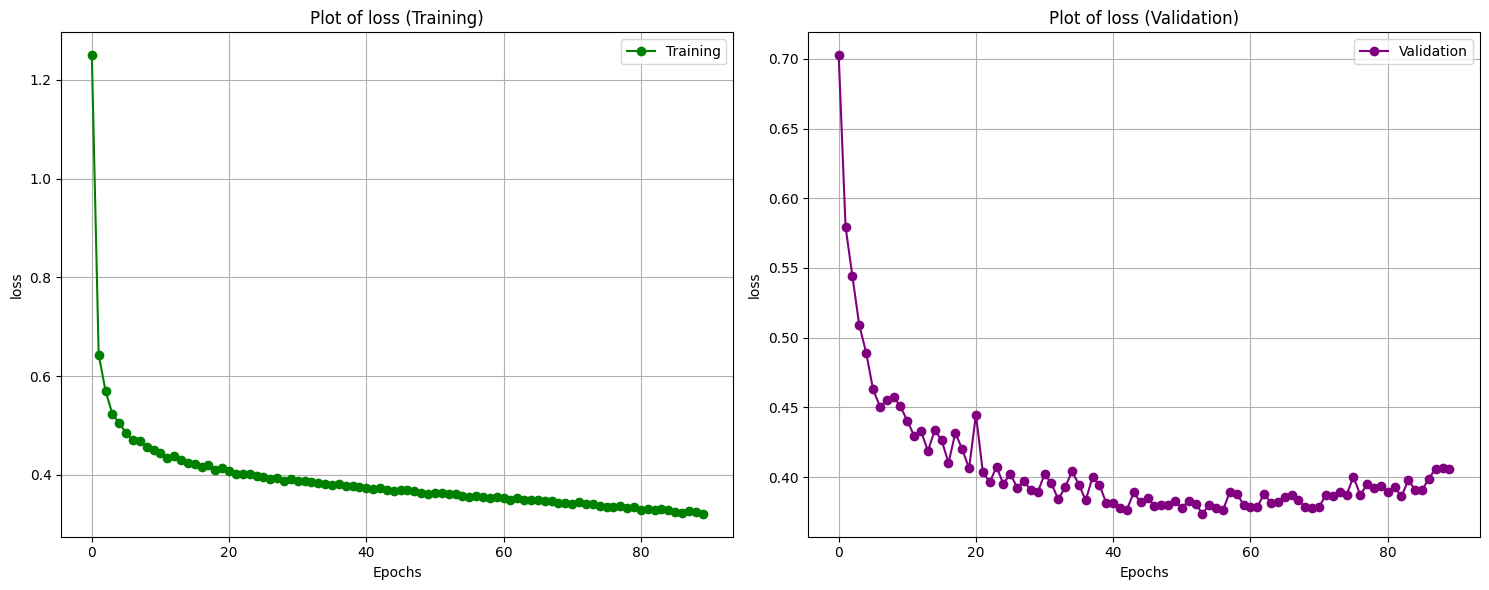

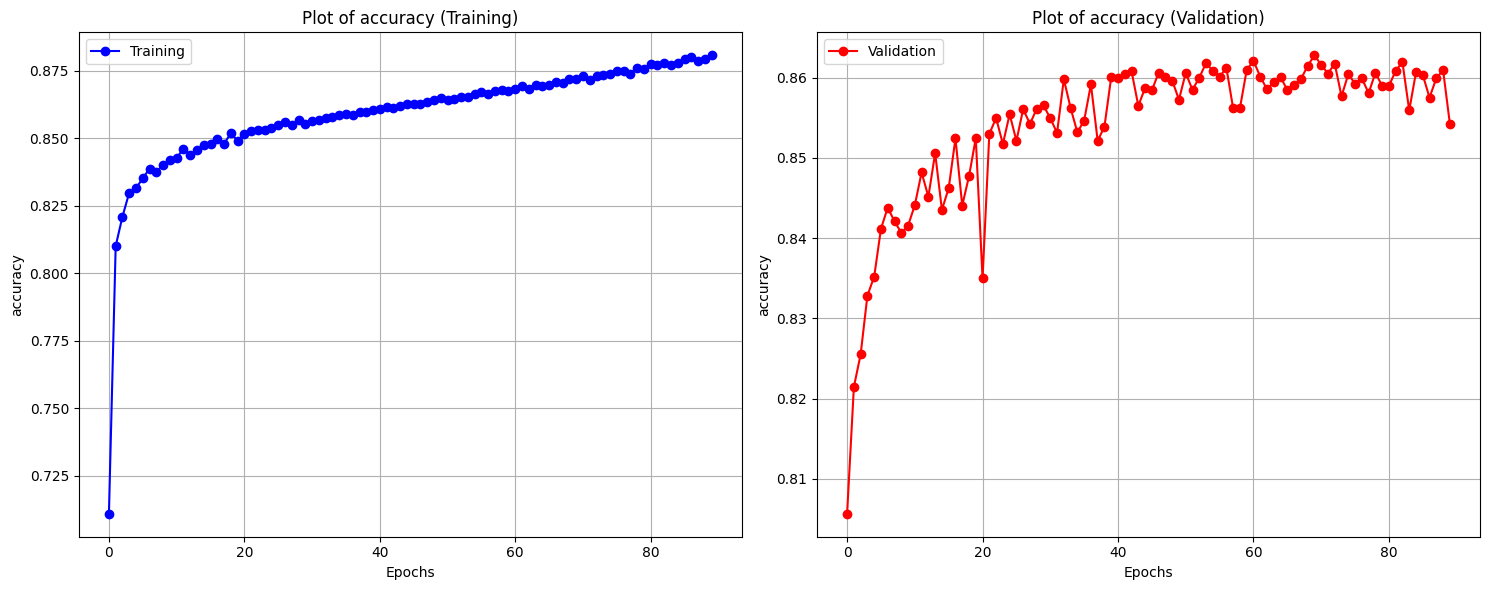

2023-10-13 18:30:01.896862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


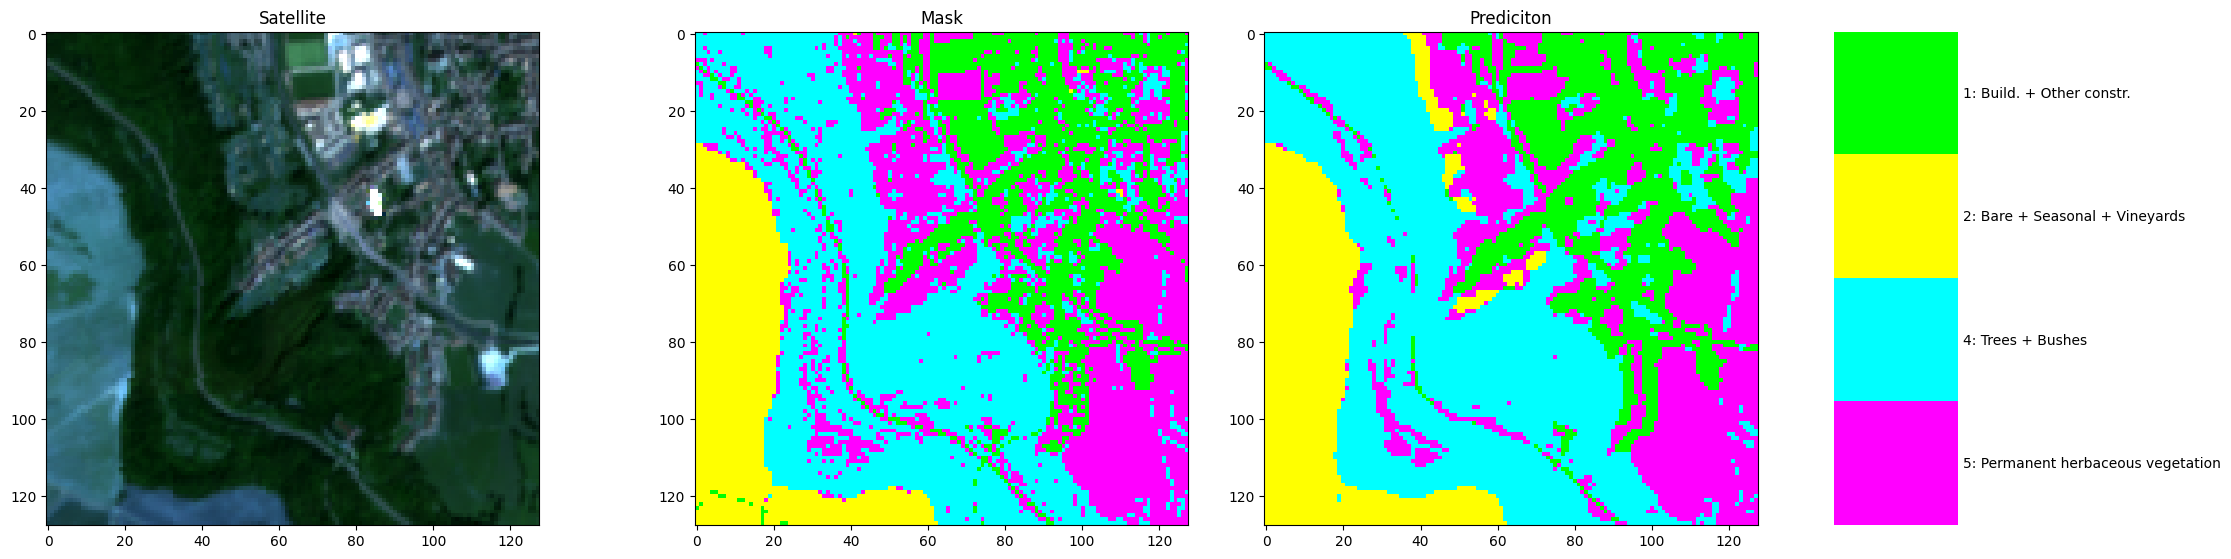

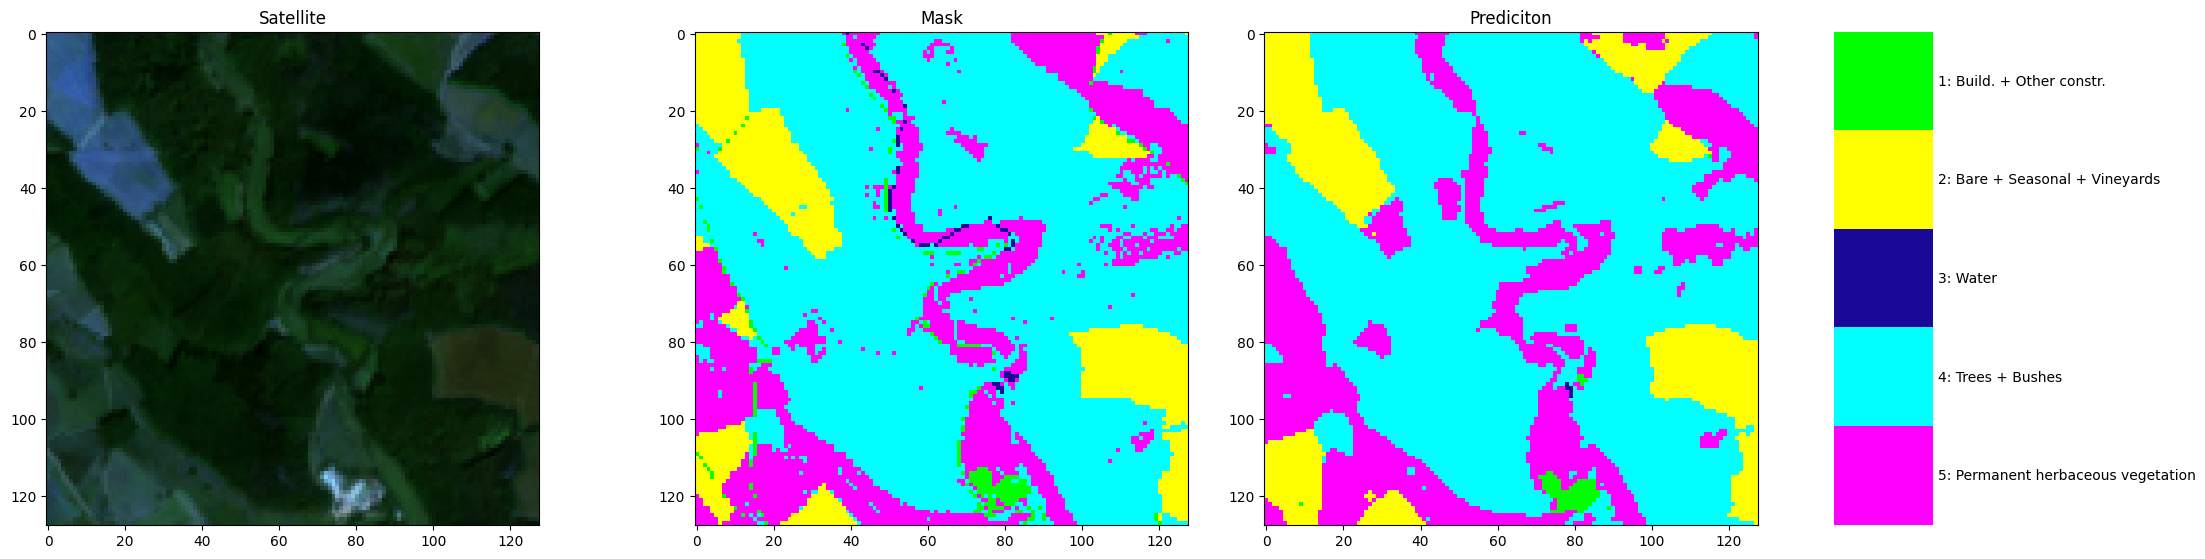

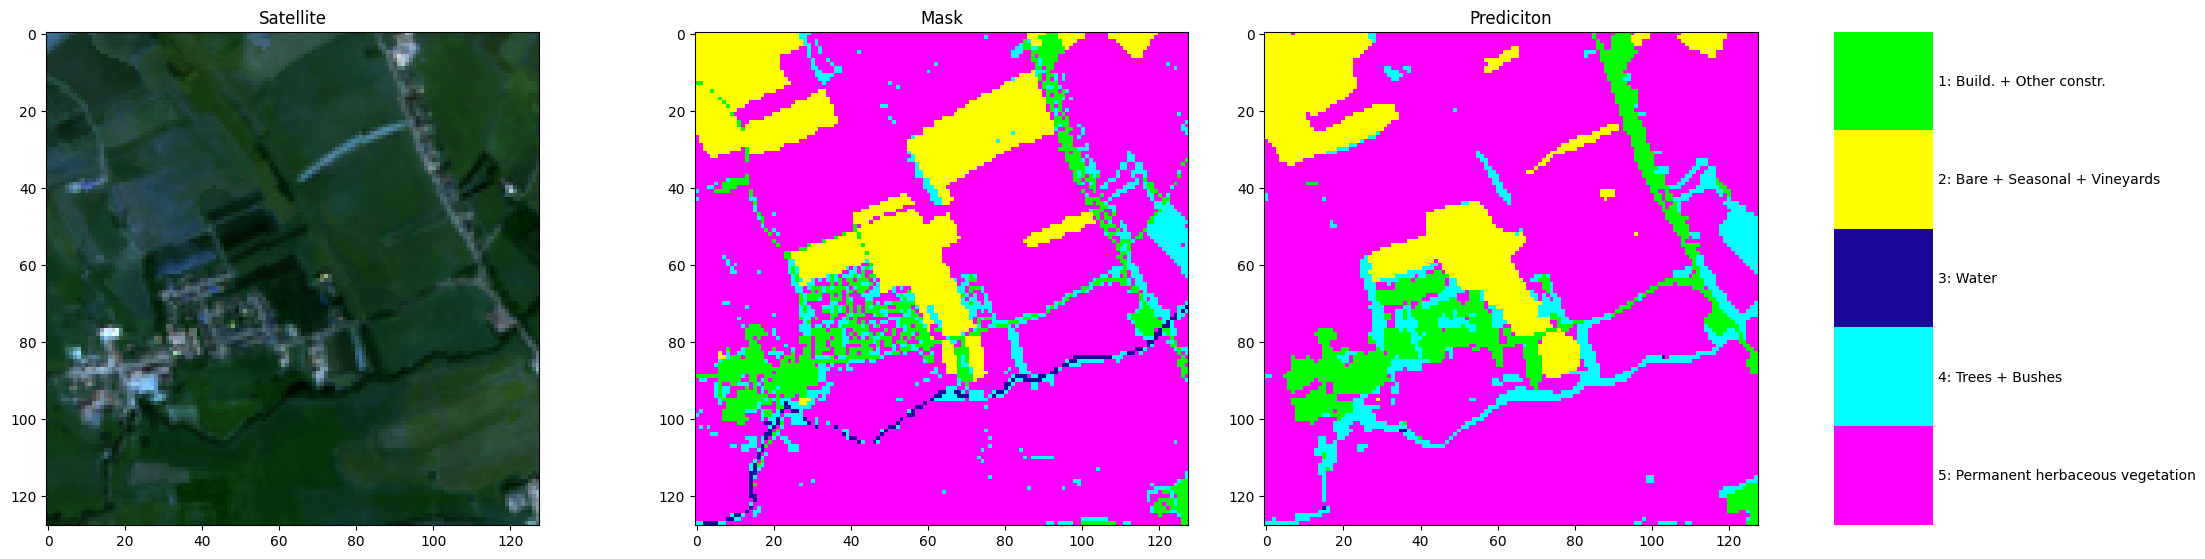

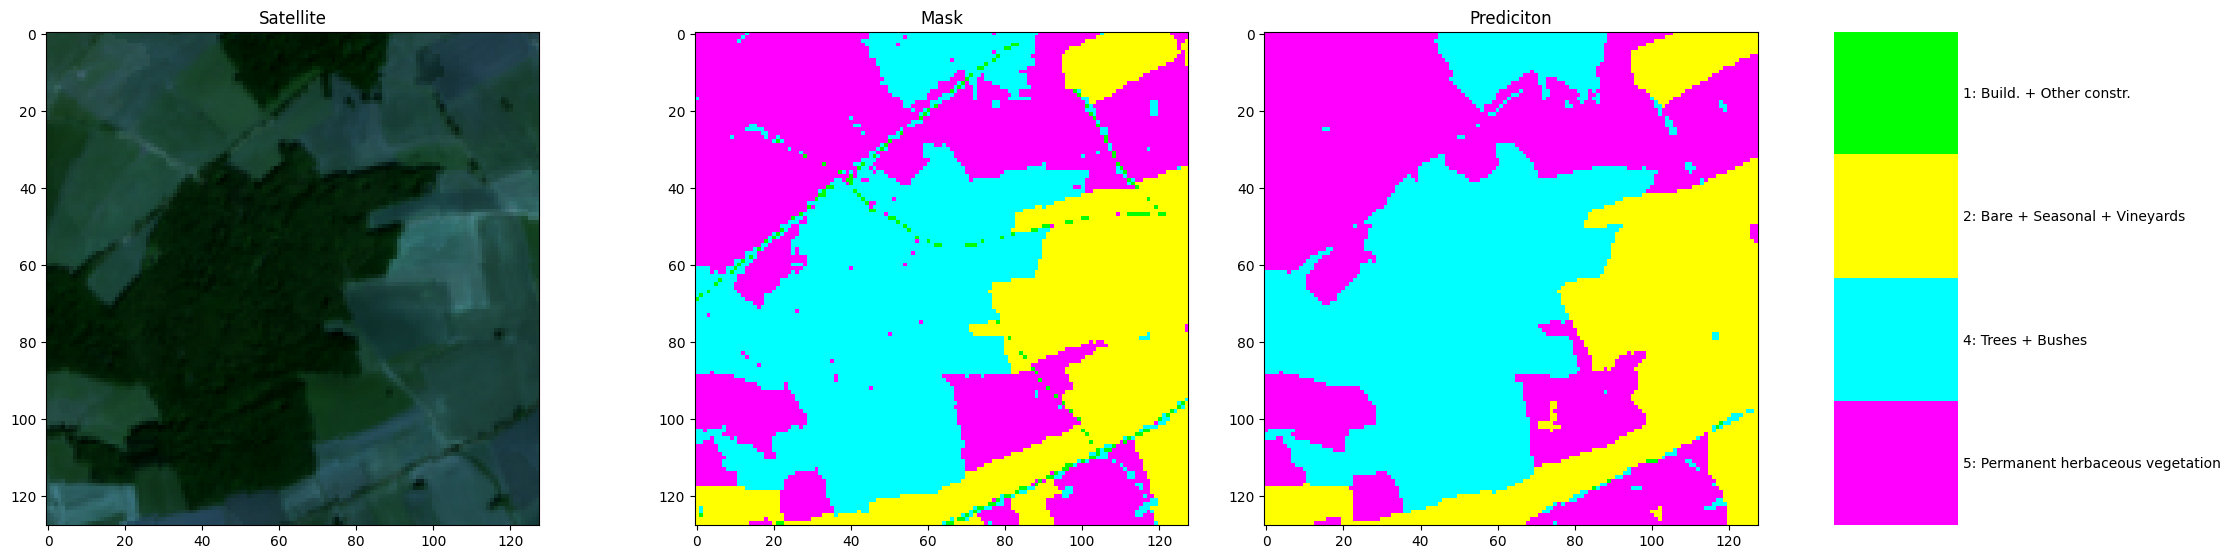

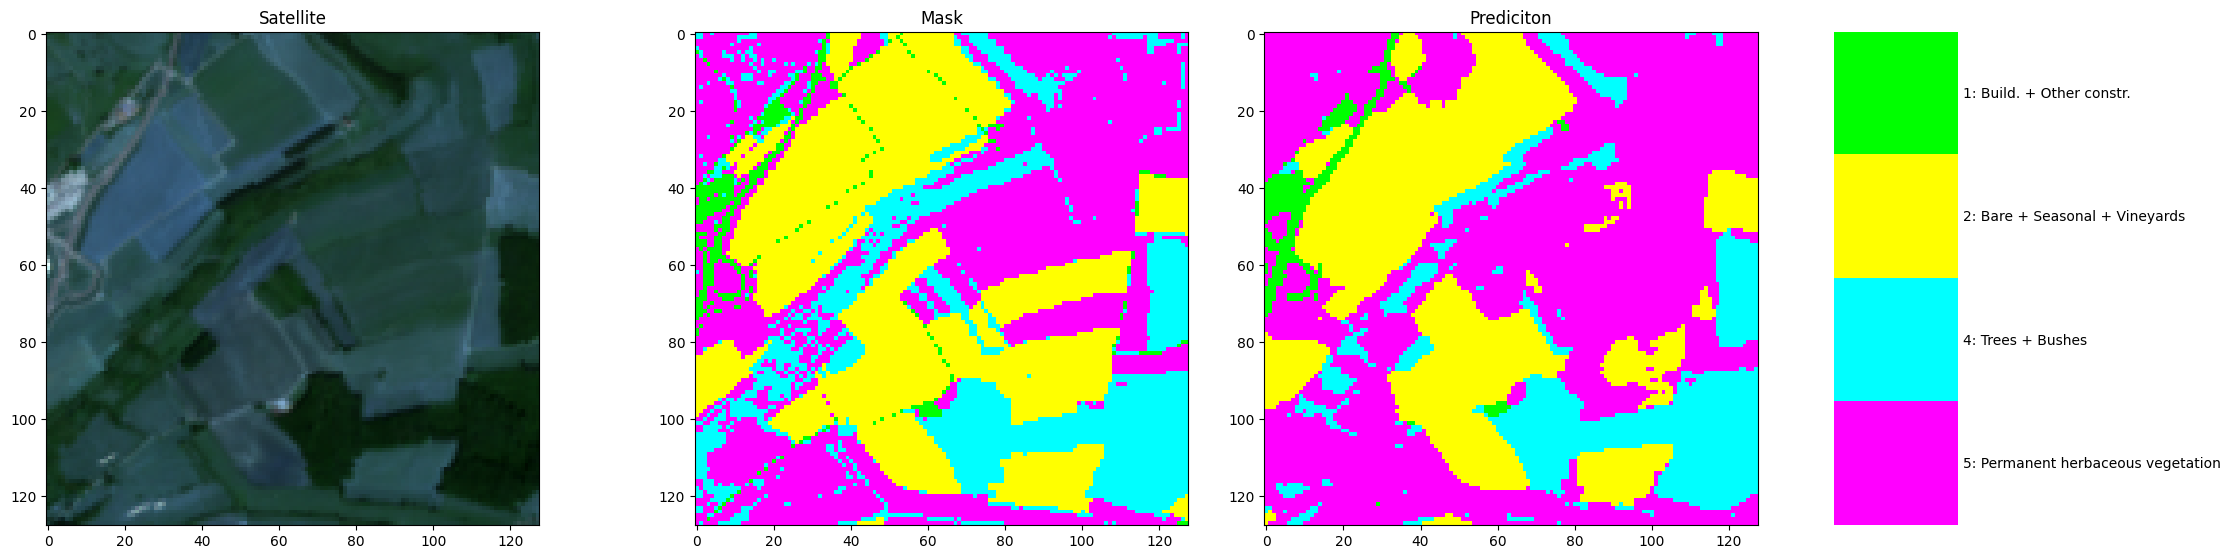

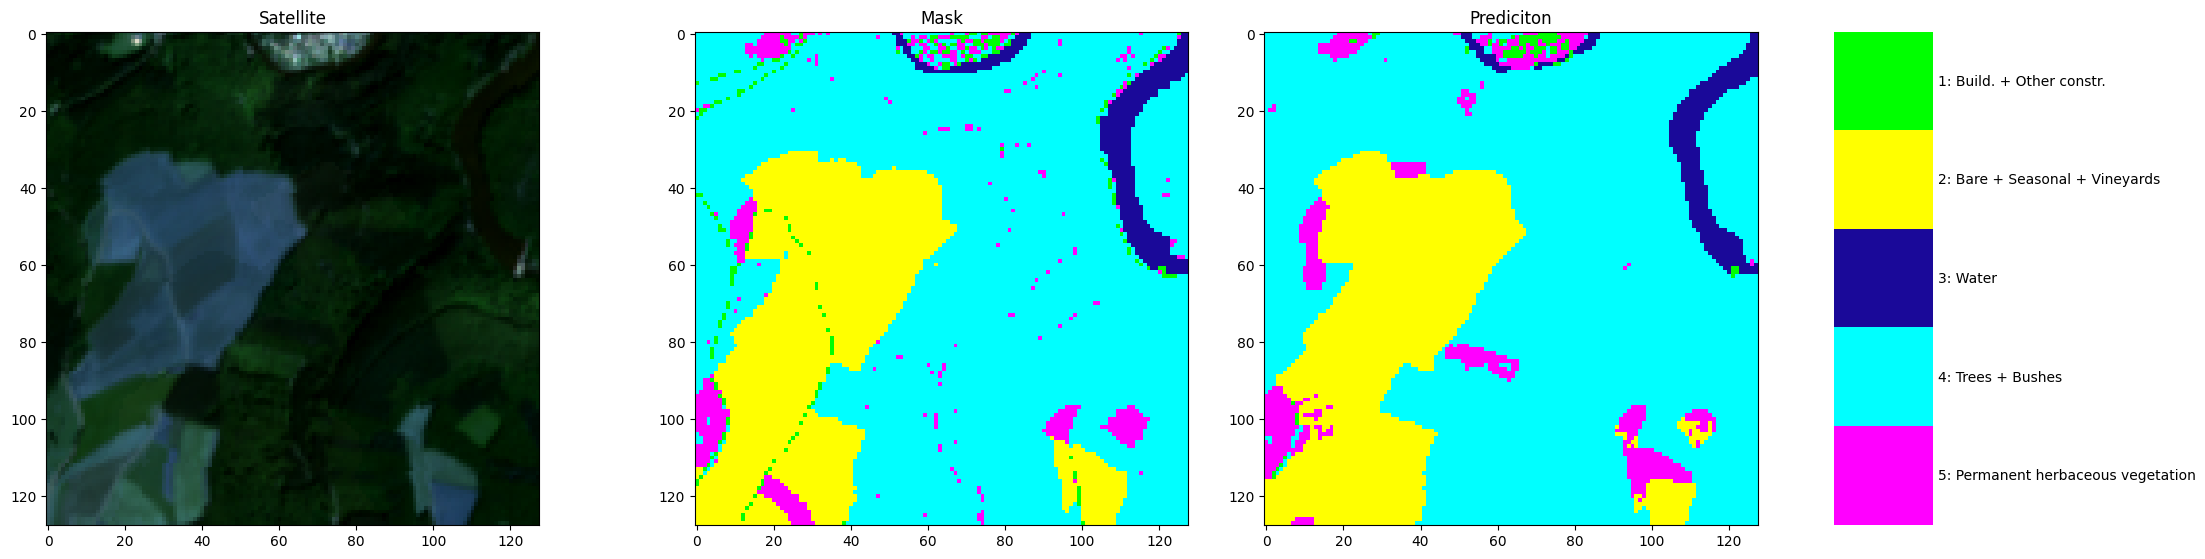

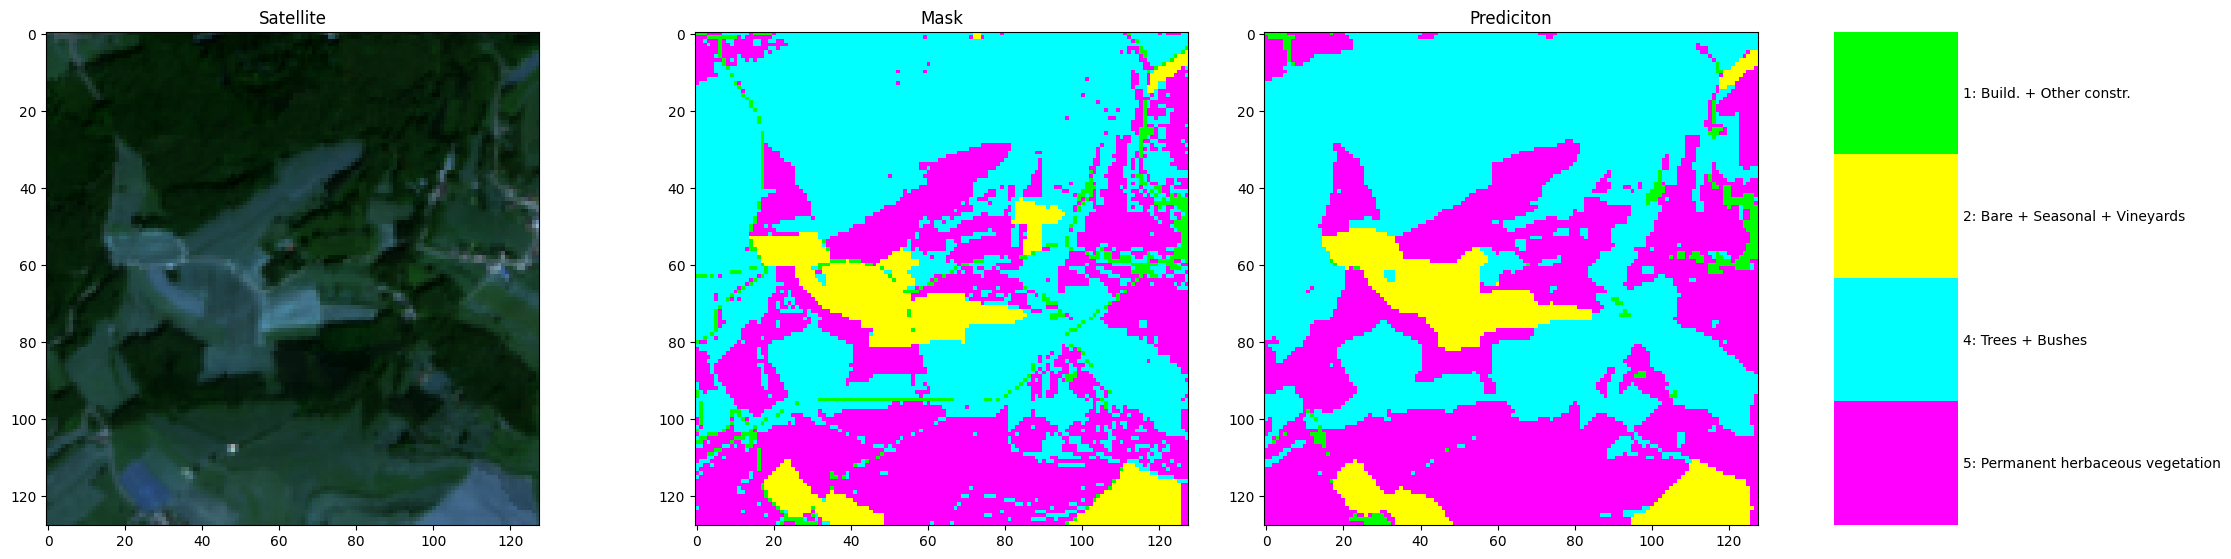

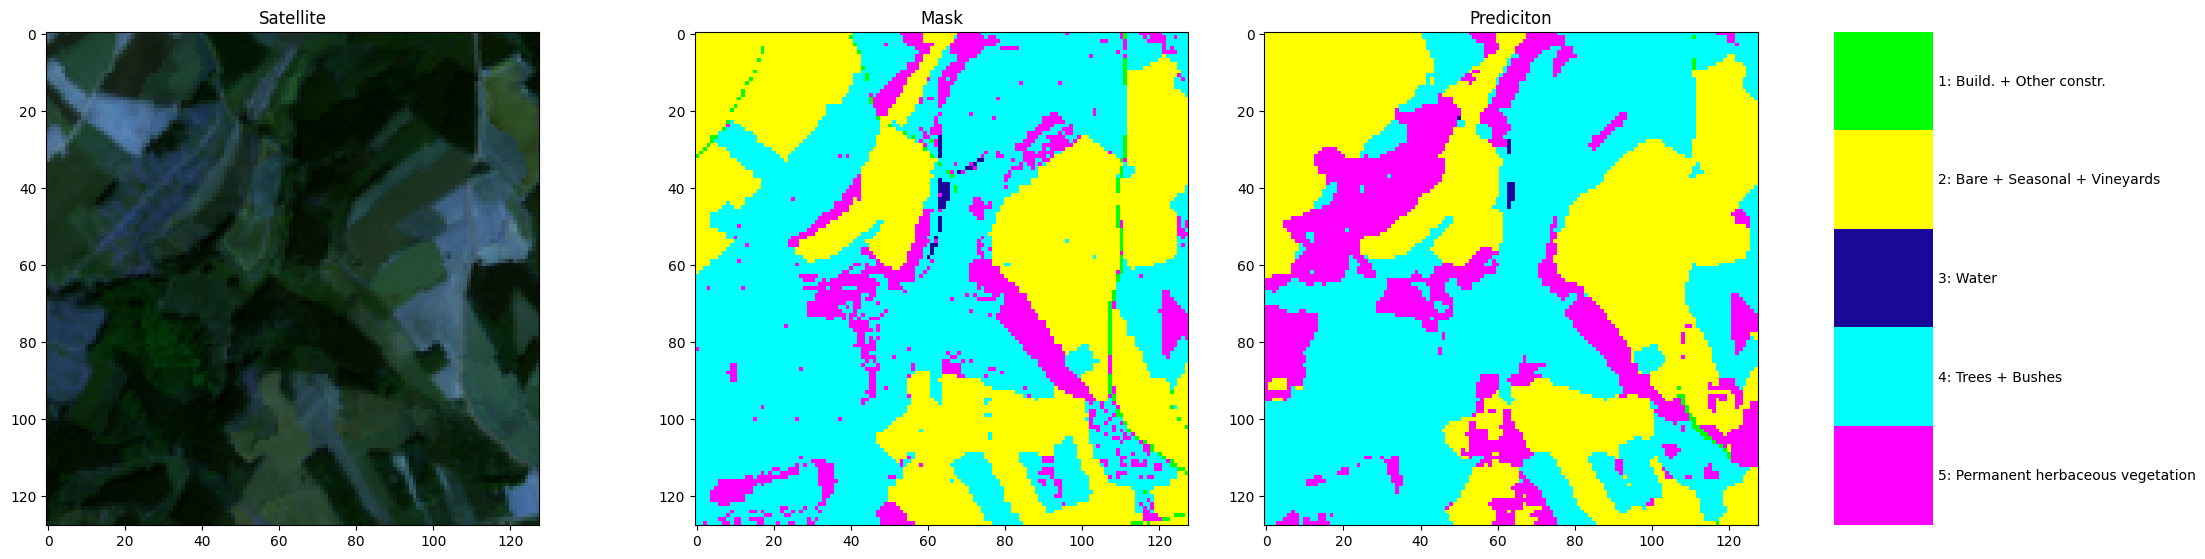

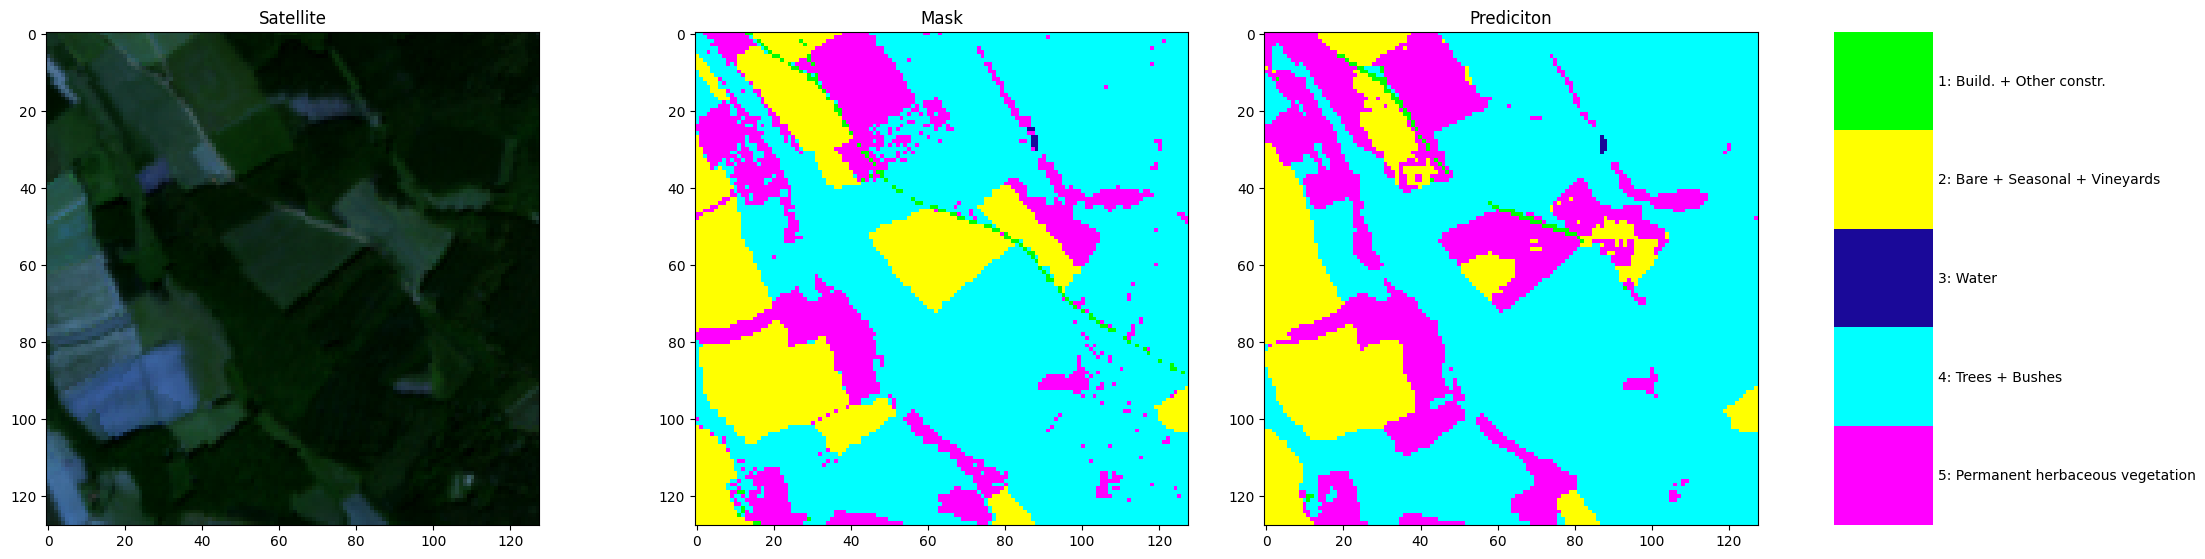

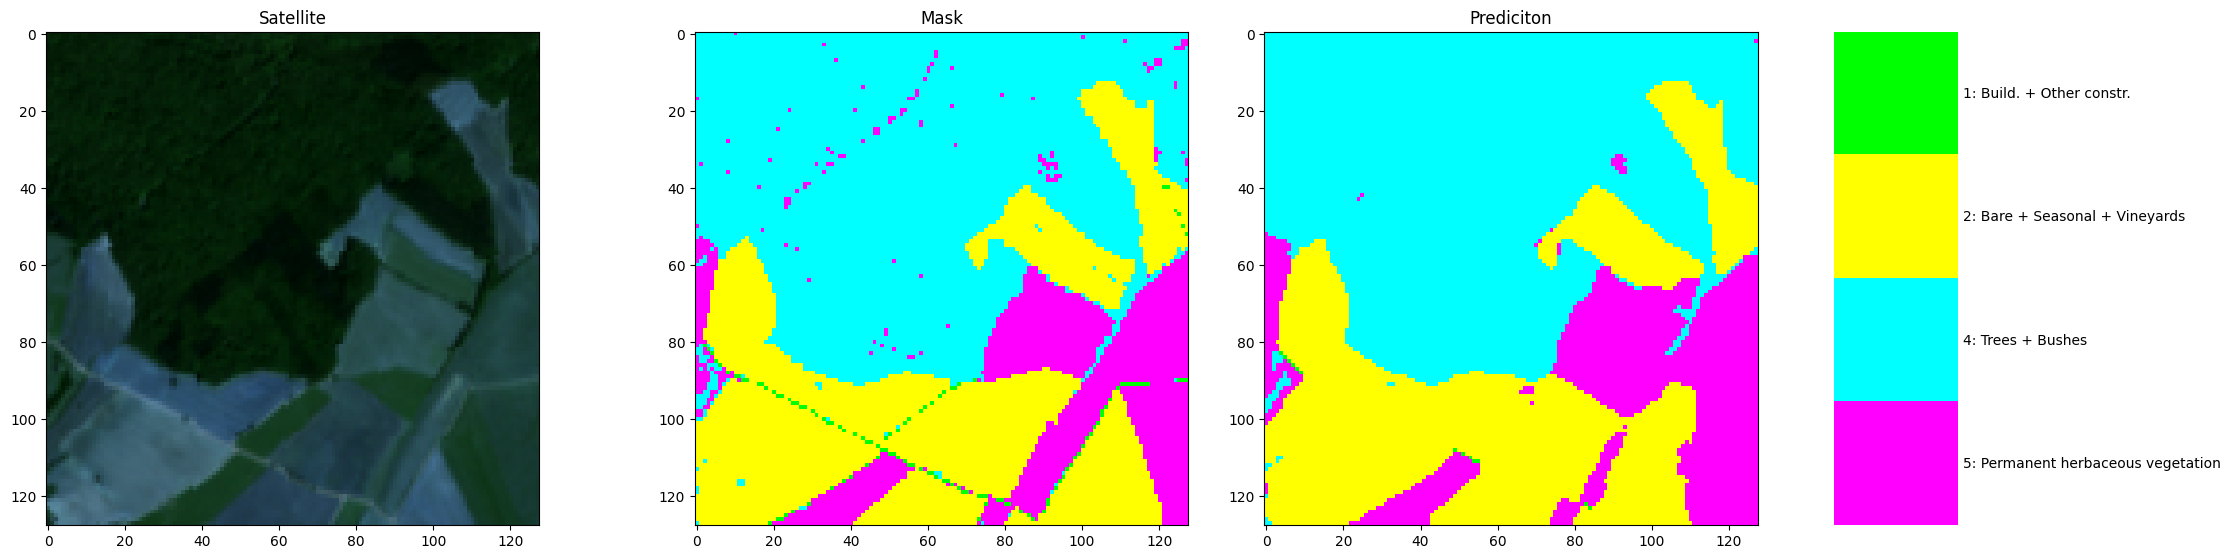

In [8]:
full_report_single_model(processed_image_ds_train, processed_image_ds_val, processed_image_ds_test, best_model, print_loss=True, print_accuracy=True, n_imgs=10, start=0)

In [9]:
MDL_ID = best_model['model_id']

In [10]:
INFERENCE_OUTPUT_DIR = f'outputs/{MDL_ID}_LU_LC_2021_pred.tif'

In [11]:
image_inference(input_img_pth = IMG_21_NORM_PTH, output_img_pth =INFERENCE_OUTPUT_DIR, model_dict = best_model, tile_size = TILE_SIZE, n_classes = 6, EPSG_code=2169, argmax = True)

100%|██████████| 8/8 [15:15<00:00, 114.50s/it]


GeoTIFF file created successfully.
